---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>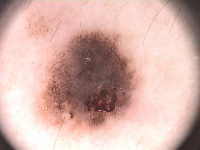</td><td>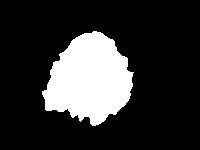</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Подгрузим наш гугл диск, на который впоследствии будет скачивать и сохранять лучшие версии наших моделей.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
! gdown https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7 -O PH2Dataset.rar
#альтернативная ссылка на данные: https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

Downloading...
From: https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7
To: /content/PH2Dataset.rar
100% 116M/116M [00:00<00:00, 127MB/s] 


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

In [ ]:
import pandas as pd

In [ ]:
import torch
import random
import numpy as np

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений используем [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

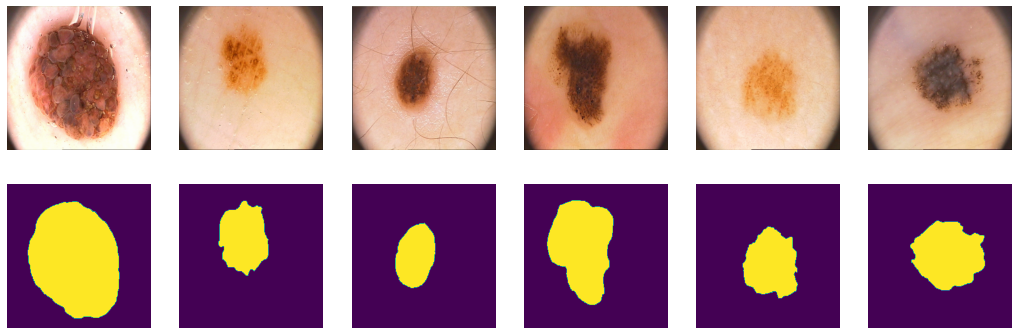

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

Раскидаем наши картинки по лоадерам.

Обратите внимание, это файл на гугл диске, в который будет сохраняться наша модель. Нам потребуется только один файл, все модели будут в нем перезаписываться. От нас не требуется сохранять наши модели.

In [ ]:
folder_to_save = '/content/drive/MyDrive/Colab Notebooks/Segmentation/model.pt'

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


-----------------------------------------------------------------------------------------

# SegNet

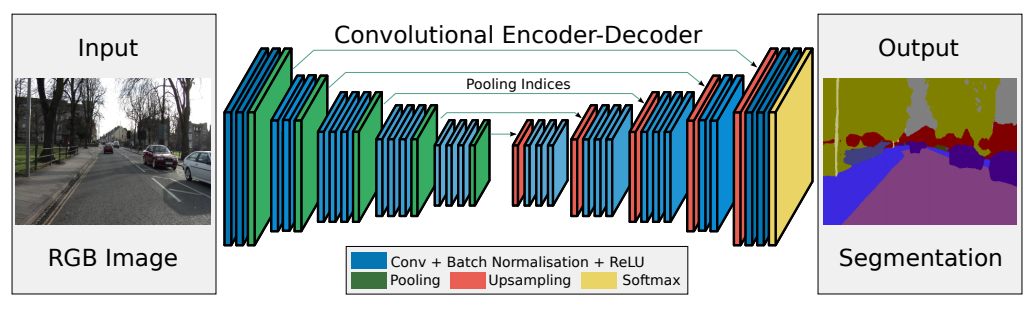

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,6)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 6, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(6),
                                       nn.ReLU(),
                                       nn.Conv2d(6, 12, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(12),
                                       nn.ReLU())
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = nn.Sequential(nn.Conv2d(12, 24, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(24),
                                       nn.ReLU(),
                                       nn.Conv2d(24, 32, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(nn.Conv2d(32, 44, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(44),
                                       nn.ReLU(),
                                       nn.Conv2d(44, 52, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(52),
                                       nn.ReLU(),
                                       nn.Conv2d(52, 64, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(nn.Conv2d(64, 80, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(80),
                                       nn.ReLU(),
                                       nn.Conv2d(80, 92, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(92),
                                       nn.ReLU(),
                                       nn.Conv2d(92, 100, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(100),
                                       nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck_conv = nn.Sequential(nn.Conv2d(100, 100, kernel_size=(1, 1)),
                                             nn.ReLU())

        self.upsample0 = nn.Upsample(size=(32, 32), mode='bilinear')
        self.dec_conv0 = nn.Sequential(nn.Conv2d(100, 92, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(92),
                                       nn.ReLU(),
                                       nn.Conv2d(92, 80, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(80),
                                       nn.ReLU(),
                                       nn.Conv2d(80, 64, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.upsample1 = nn.Upsample(size=(64, 64), mode='bilinear')
        self.dec_conv1 = nn.Sequential(nn.Conv2d(64, 52, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(52),
                                       nn.ReLU(),
                                       nn.Conv2d(52, 44, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(44),
                                       nn.ReLU(),
                                       nn.Conv2d(44, 32, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.upsample2 = nn.Upsample(size=(128, 128), mode='bilinear')
        self.dec_conv2 = nn.Sequential(nn.Conv2d(32, 24, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(24),
                                       nn.ReLU(),
                                       nn.Conv2d(24, 12, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(12),
                                       nn.ReLU())
        self.upsample3 = nn.Upsample(size=(256, 256), mode='bilinear')
        self.dec_conv3 = nn.Sequential(nn.Conv2d(12, 6, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(6),
                                       nn.ReLU(),
                                       nn.Conv2d(6, 1, kernel_size=(3, 3), padding=1))

    def forward(self, x):
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        b = self.bottleneck_conv(e3)
        
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))
        return d3


## Метрика

В данном разделе будем использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte() 
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Поэтому мы будем использовать следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    loss = (y_pred > 0) * y_pred - y_real * y_pred + torch.log(1 + torch.exp(-abs(y_pred)))
    loss = loss.mean()
    return loss

## Тренировка

Определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, folder, metric, scheduler):
    X_val, Y_val = next(iter(data_val))
    best_loss = 99999999
    losses_train = []
    losses_val = []
    accuracies_train = []
    accuracies_val = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        model = model.to(device)
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch).to(device)
            loss = bce_loss(Y_batch, Y_pred)
            losses_train.append(loss.item())   #for visual
            acc = (metric(((torch.sigmoid(Y_pred)>0.5).byte()).to(device), Y_batch.to(device)).mean()).item() #also for visual
            accuracies_train.append(acc)
            loss.backward()  
            opt.step()  # update weights
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        if avg_loss < best_loss:
          best_loss = avg_loss
          torch.save(model.state_dict(), folder)
        scheduler.step()  #scheduler

        # show intermediate results
        model.eval()  # testing mode
        model = model.to('cpu')
        with torch.no_grad():
          Y_hat = model(X_val)
          #for visual
          losses_val.append((bce_loss(Y_val, Y_hat)).item()) 
          accuracies_val.append((metric(((torch.sigmoid(Y_hat)>0.5).byte()).to(device), Y_val.to(device)).mean()).item())
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='plasma')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='plasma')
            plt.title('Output v1')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(((torch.sigmoid(Y_hat)>0.5).byte())[k, 0], cmap='plasma')
            plt.title('Output v2')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return losses_train, losses_val, accuracies_train, accuracies_val

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()
    model = model.to('cpu')
    data = data.to('cpu')
    with torch.no_grad():
      Y_pred = model(data)
    return Y_pred

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    model = model.to('cpu')
    with torch.no_grad():
      for X_batch, Y_label in data:
          X_batch, Y_label = X_batch.to('cpu'), Y_label.to('cpu')
          Y_pred = predict(model, X_batch)
          Y_pred = (torch.sigmoid(Y_pred)>0.5).byte()
          scores += metric(Y_pred.to(device), Y_label.to(device)).mean().item()
    return scores/len(data)

## Основной момент: обучение


In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
step_size = 30
lr = 1e-3
gamma = 0.3

Я использую один оптимизатор для всех моделей - AdamW. Также я использую динамический learning rate посредством scheduler. Параметры для него я проверял и подбирал вручную, это заняло порядочно времени, зато результат был порядочно лучше, чем без него (прирост в точности порядка 10%).

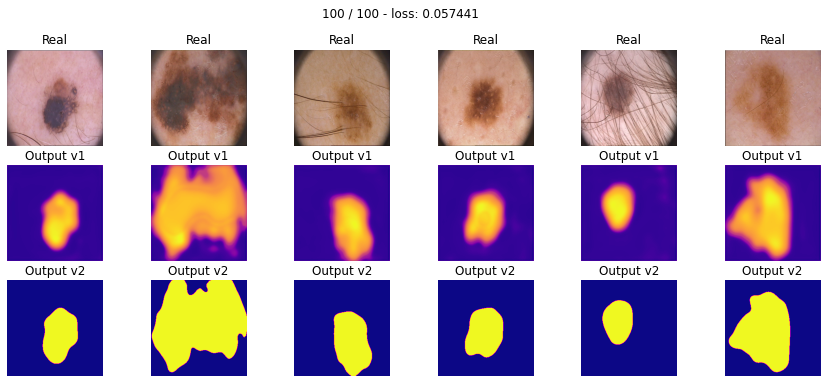

In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=step_size, gamma=gamma, verbose=False)
losses_train, losses_val, accuracies_train, accuracies_val = train(model, optim, bce_loss, max_epochs, data_tr, data_val, folder_to_save, iou_pytorch, scheduler)

В целом, все изображения очень хорошо сегментировались. Из придирок разве что последнее не очень четко.

Дальше идут функции для отрисовки графиков.

In [ ]:
def avg_func(losses_train, accuracies_train):
  avg_loss = []
  avg_acc = []
  N = len(data_tr)
  avg_loss_temp = 0
  avg_acc_temp = 0
  #losses_train.shape = accuracies_train.shape
  for i in range(len(losses_train)):
    if i%N == (N-1):
      avg_loss.append(avg_loss_temp)
      avg_acc.append(avg_acc_temp)
      avg_loss_temp = 0
      avg_acc_temp = 0
    else:
      avg_acc_temp += accuracies_train[i] / N
      avg_loss_temp += losses_train[i] / N
  return avg_loss, avg_acc

In [ ]:
def min_max(value_names, i, value, ax, legend=True):
  if value_names[i] in ['losses_train', 'losses_val']:
    min_value = min(value)
    min_idx = [j for j, _ in enumerate(value) if _==min_value]
    min_val = [min_value for _ in range(len(min_idx))]
    if legend:
      ax[i].scatter(min_idx, min_val, label='min value', color='red')
    else:
      ax[i].scatter(min_idx, min_val, color='red')
  elif value_names[i] in ['accuracies_train', 'accuracies_val']:
    max_value = max(value)
    max_idx = [j for j, _ in enumerate(value) if _==max_value]
    max_val = [max_value for _ in range(len(max_idx))]
    if legend:
      ax[i].scatter(max_idx, max_val, label='max value', color='red')
    else:
      ax[i].scatter(max_idx, max_val, color='red')

In [ ]:
def visual(values, avg_loss, avg_acc):
  value_names = ['losses_train', 'accuracies_train', 'losses_val', 'accuracies_val']
  fig, ax = plt.subplots(2, 2, figsize=(15, 10))
  ax = ax.ravel()
  for i, value in enumerate(values):
    ax[i].plot(value, label=value_names[i])
    min_max(value_names, i, value, ax)
    if value_names[i] == 'losses_val':
      ax[i].set_title(value_names[i]+' compare with losses_train by epochs')
      ax[i].plot(avg_loss, label='losses_train')
      min_max(value_names, i, avg_loss, ax, legend=False)

    elif value_names[i] == 'accuracies_val':
      ax[i].set_title(value_names[i]+' compare with accuracies_train by epochs')
      ax[i].plot(avg_acc, label='accuracies_train')
      min_max(value_names, i, avg_acc, ax, legend=False)

    elif value_names[i] == 'losses_train':
      ax[i].set_title(value_names[i]+' by every batch')

    elif value_names[i] == 'accuracies_train':
      ax[i].set_title(value_names[i]+' by every batch')

    legend_box = ax[i].legend().get_frame()

  fig.show()

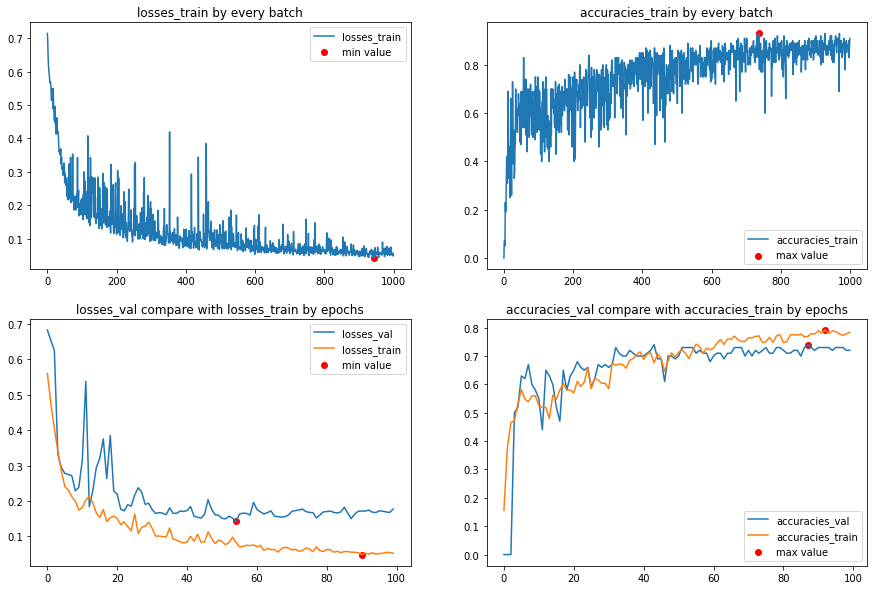

In [ ]:
values = [losses_train, accuracies_train, losses_val, accuracies_val]
avg_loss, avg_acc = avg_func(losses_train, accuracies_train)
visual(values, avg_loss, avg_acc)

Я не стал делать accuracy_val и loss_val по батчам, чтобы не перегружать программу. Это совсем не сложно и при желании я мог бы это сделать, но я просто не вижу смысла. Вероятнее всего график получится очень шумным и хаотичным, потому что некоторые картинки сетка распознавала совершенно не сразу.

На этом графике мы видим плавное убывание лосса на трейне и корявое на вале. К тому же, на вале у нас лосс перестает изменяться спустя эпох 40-50, но на трейне продолжает уменьшаться. С точностью у нас та же история. Вообще в целом, это явление будет характерно для большинства графиков, так что я не буду больше на этом останавливаться.

In [ ]:
seg11 = score_model(model, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Подгрузим нашу лучшую модель (опираясь на трейновый лосс по эпохам)

In [ ]:
model.load_state_dict(torch.load(folder_to_save))

<All keys matched successfully>

In [ ]:
seg12 = score_model(model, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Ответьте себе на вопрос: не переобучается ли моя модель?

Модель определенно не переобучается. Гэпы между графиками лоссов и скора у нас небольшие, точность на тестовой выборке не сильно ниже, чем на валидационной (а может и выше даже)

In [ ]:
print(seg11, seg12)

0.7180000424385071 0.7260000586509705


-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

 В данном разделе мы имплементируем две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

In [ ]:
def dice_loss(y_real, y_pred):
    num = (2 * y_pred * y_real) / torch.clamp((y_pred + y_real), min=1e-8)
    den = (1/(256*256)) * num
    res = 1 - den
    return res.mean()

От численной нестабильности нам помогает избавиться torch.clamp, которым мы ограничиваем нашу функцию от нуля в знаменателе.

Проводим тестирование:

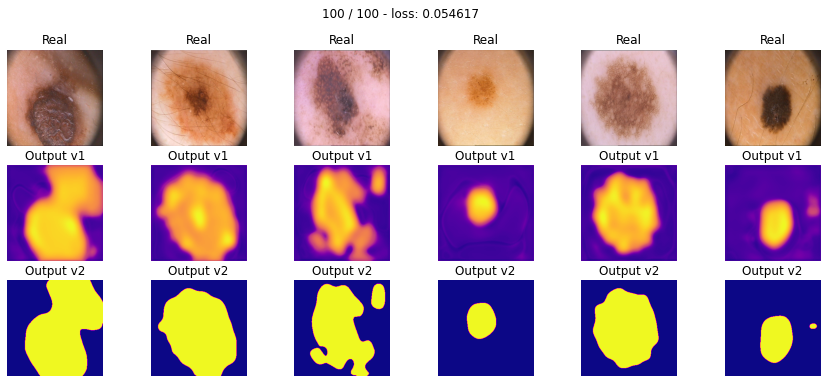

In [ ]:
model_dice = SegNet().to(device)
optimaizer = torch.optim.AdamW(model_dice.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimaizer, step_size=step_size, gamma=gamma, verbose=False)
losses_train, losses_val, accuracies_train, accuracies_val = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, folder_to_save, iou_pytorch, scheduler)

Я не знаю как судить данную сегментацию, потому что я сам не могу нормально сегментировать первые три картинки. Но, полагаю, сетка справилась неплохо.

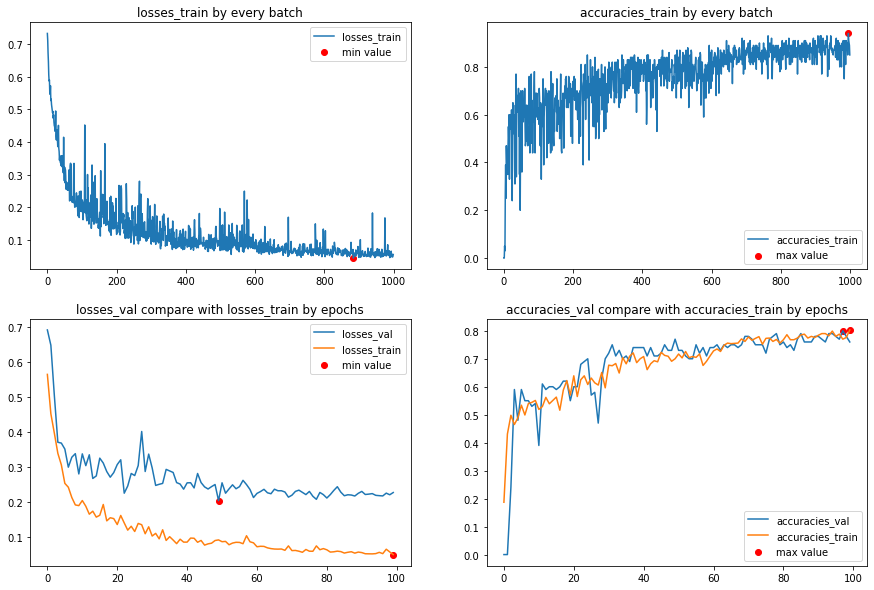

In [ ]:
values = [losses_train, accuracies_train, losses_val, accuracies_val]
avg_loss, avg_acc = avg_func(losses_train, accuracies_train)
visual(values, avg_loss, avg_acc)

Похожая ситуация, что и в первом случае. Гэп на лоссах несколько больше, зато и скор на вале больше. Ниже увидим табличку со сравнением всех скоров SegNet модели.

In [ ]:
seg21 = score_model(model_dice, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
model_dice.load_state_dict(torch.load(folder_to_save))

<All keys matched successfully>

In [ ]:
seg22 = score_model(model_dice, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    # hint: torch.clamp
    loss = -(torch.clamp(torch.pow((1-torch.sigmoid(y_pred)),gamma),min=eps,max=1)*y_real*torch.log(torch.sigmoid(y_pred))+(1-y_real)*torch.log(1-torch.sigmoid(y_pred)))
    return loss.mean()


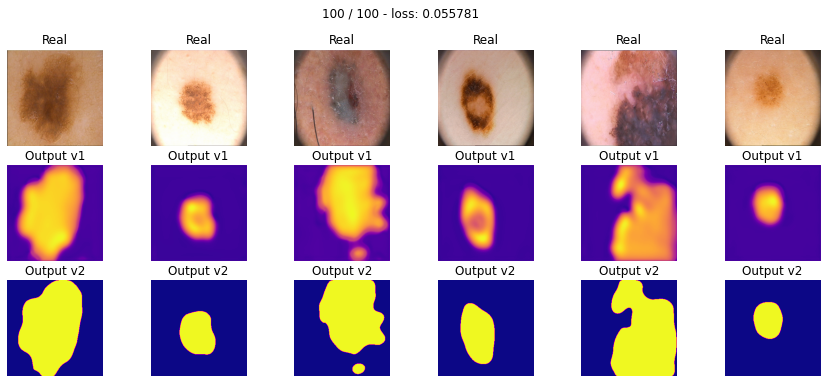

In [ ]:
model_focal = SegNet().to(device)

optimaizer = torch.optim.AdamW(model_focal.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimaizer, step_size=step_size, gamma=gamma, verbose=False)
losses_train, losses_val, accuracies_train, accuracies_val = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, folder_to_save, iou_pytorch, scheduler)

Здесь сегментация мне совсем не понравилась, очень неточная.

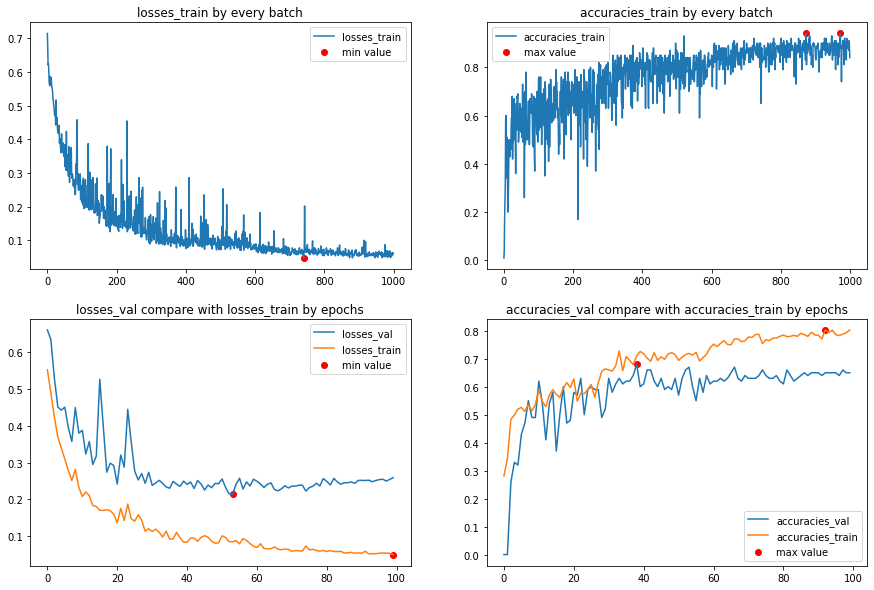

In [ ]:
values = [losses_train, accuracies_train, losses_val, accuracies_val]
avg_loss, avg_acc = avg_func(losses_train, accuracies_train)
visual(values, avg_loss, avg_acc)

Графики лоссов начали сильно расходиться после 60 эпохи. Также странно, что лосс на вале начал даже расти, а не убывать.

In [ ]:
seg31 = score_model(model_focal, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
model_focal.load_state_dict(torch.load(folder_to_save))

<All keys matched successfully>

In [ ]:
seg32 = score_model(model_focal, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
accs = {'bce':[seg11, seg12], 'dice':[seg21, seg22], 'focal':[seg31, seg32]}
df = pd.DataFrame(data=accs, index=['last condition', 'best condition'])
df

,bce,dice,focal
last condition,0.718,0.734,0.734
best condition,0.726,0.734,0.734


last condition - скор обученной модели

best condition - скор из подгруженной модели с самым низким лоссом на трейне

***ИТОГО про SegNet:*** Мне больше всего понравились графики и изображения первой модели (BCELoss), но, как мы видим из таблички выше, две другие модели показали результаты на тестовой выборке лучше. 

-----------------------------------------------------------------------------------------

# U-Net

**U-Net** — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

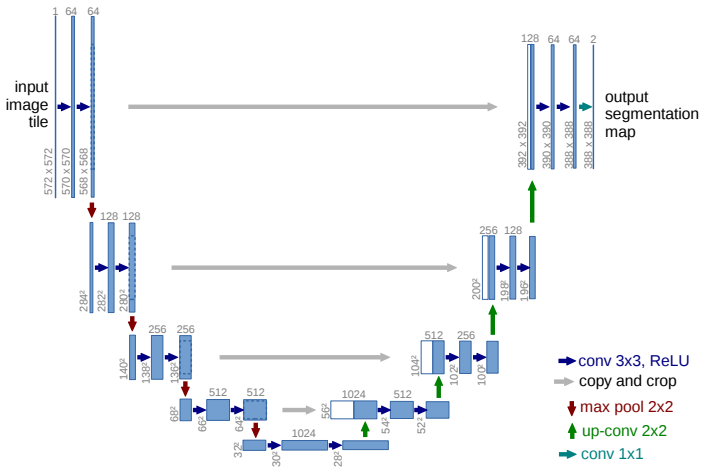

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 6, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(6),
                                       nn.ReLU(),
                                       nn.Conv2d(6, 12, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(12),
                                       nn.ReLU())
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = nn.Sequential(nn.Conv2d(12, 24, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(24),
                                       nn.ReLU(),
                                       nn.Conv2d(24, 32, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(nn.Conv2d(32, 44, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(44),
                                       nn.ReLU(),
                                       nn.Conv2d(44, 52, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(52),
                                       nn.ReLU(),
                                       nn.Conv2d(52, 64, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(nn.Conv2d(64, 80, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(80),
                                       nn.ReLU(),
                                       nn.Conv2d(80, 92, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(92),
                                       nn.ReLU(),
                                       nn.Conv2d(92, 100, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(100),
                                       nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck_conv = nn.Sequential(nn.Conv2d(100, 100, kernel_size=(1, 1)),
                                             nn.ReLU())

        self.upsample0 = nn.Upsample(size=(32, 32), mode='bilinear')
        self.dec_conv0 = nn.Sequential(nn.Conv2d(200, 164, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(164),
                                       nn.ReLU(),
                                       nn.Conv2d(164, 128, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.upsample1 = nn.Upsample(size=(64, 64), mode='bilinear')
        self.dec_conv1 = nn.Sequential(nn.Conv2d(128, 80, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(80),
                                       nn.ReLU(),
                                       nn.Conv2d(80, 60, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(60),
                                       nn.ReLU(),
                                       nn.Conv2d(60, 32, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.upsample2 = nn.Upsample(size=(128, 128), mode='bilinear')
        self.dec_conv2 = nn.Sequential(nn.Conv2d(64, 36, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(36),
                                       nn.ReLU(),
                                       nn.Conv2d(36, 12, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(12),
                                       nn.ReLU())
        self.upsample3 = nn.Upsample(size=(256, 256), mode='bilinear')
        self.dec_conv3 = nn.Sequential(nn.Conv2d(24, 12, kernel_size=(3, 3), padding=1),
                                       nn.BatchNorm2d(12),
                                       nn.ReLU(),
                                       nn.Conv2d(12, 1, kernel_size=(3, 3), padding=1))

    def forward(self, x):
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_conv0(self.upsample0(torch.cat((b, e3), dim=1)))
        d1 = self.dec_conv1(self.upsample1(torch.cat((d0, e2), dim=1)))
        d2 = self.dec_conv2(self.upsample2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(self.upsample3(torch.cat((d2, e0), dim=1)))
        return d3


In [ ]:
unet_model_bce = UNet().to(device)

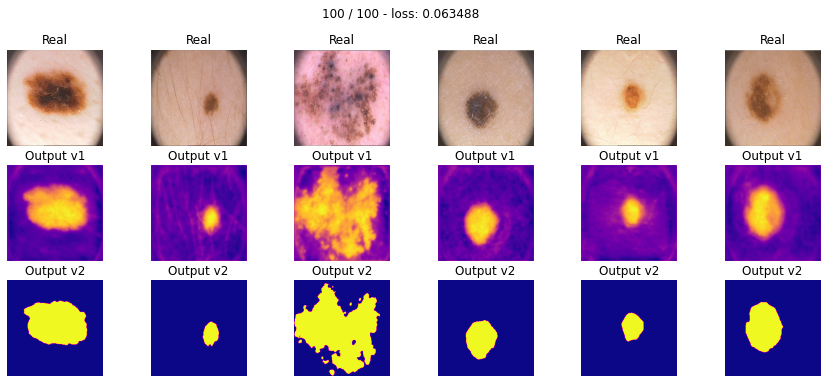

In [ ]:
optimaizer = torch.optim.AdamW(unet_model_bce.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimaizer, step_size=step_size, gamma=gamma, verbose=False)
losses_train, losses_val, accuracies_train, accuracies_val = train(unet_model_bce, optimaizer, bce_loss, max_epochs, data_tr, data_val, folder_to_save, iou_pytorch, scheduler)

Самая приятная сегментация из всех. Если смотреть на вторую линию графиков, то верно сегментированы практически все пиксели на всех картинках, это очень круто. ❤❤❤❤❤❤❤❤❤❤❤❤

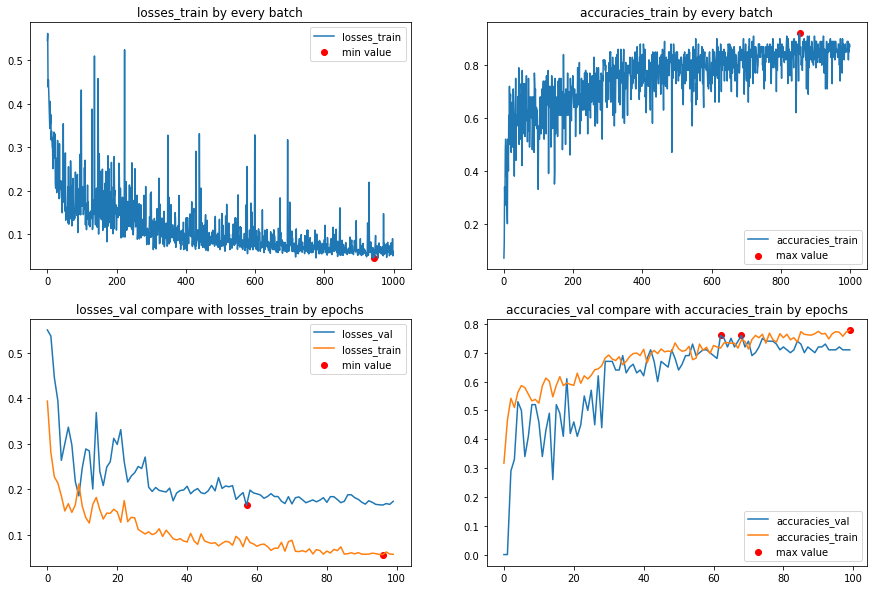

In [ ]:
values = [losses_train, accuracies_train, losses_val, accuracies_val]
avg_loss, avg_acc = avg_func(losses_train, accuracies_train)
visual(values, avg_loss, avg_acc)

График лосса и метрики также вполне приличный. Эта модель определенно имеет высокие шансы стать лучшей.

In [ ]:
unet11 = score_model(unet_model_bce, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
unet_model_bce.load_state_dict(torch.load(folder_to_save))

<All keys matched successfully>

In [ ]:
unet12 = score_model(unet_model_bce, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Проверяем модель на FocalLoss

In [ ]:
unet_model_focal = UNet().to(device)

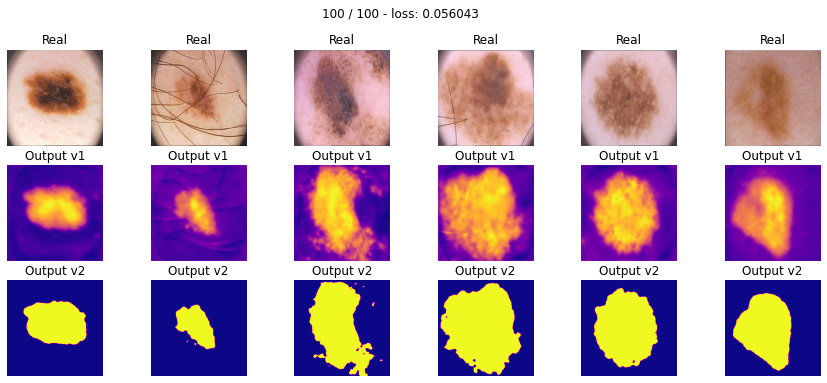

In [ ]:
optimaizer = torch.optim.Adam(unet_model_focal.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimaizer, step_size=step_size, gamma=gamma, verbose=False)
losses_train, losses_val, accuracies_train, accuracies_val = train(unet_model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, folder_to_save, iou_pytorch, scheduler)

Эта модель показала также блестящие результаты в плане сегментации. Определенно лучше всех моделей SegNet точно, на равне в предыдущей моделью.

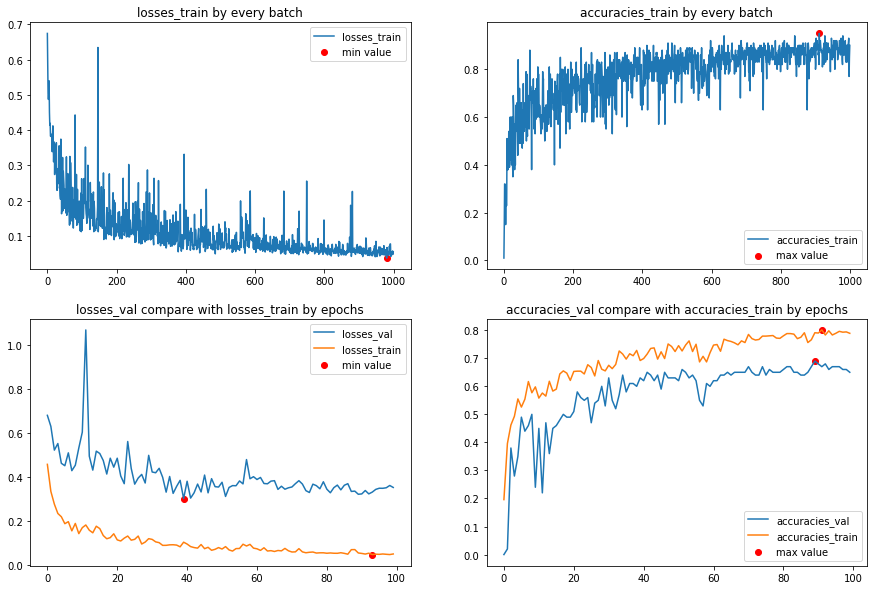

In [ ]:
values = [losses_train, accuracies_train, losses_val, accuracies_val]
avg_loss, avg_acc = avg_func(losses_train, accuracies_train)
visual(values, avg_loss, avg_acc)

График лоссов несколько хуже, чем у предыдущей, из-за довольно большого гэпа. Но в целом, он тоже не критичный. График метрики, правда, на удивление низко лежит, хотя казалось бы, сегментация была очень успешная.

In [ ]:
unet21 = score_model(unet_model_focal, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
unet_model_focal.load_state_dict(torch.load(folder_to_save))

<All keys matched successfully>

In [ ]:
unet22 = score_model(unet_model_focal, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


И DiceLoss

In [ ]:
unet_model_dice = UNet().to(device)

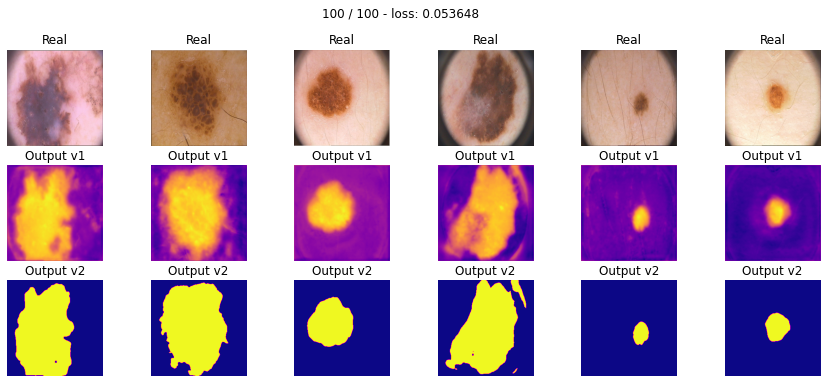

In [ ]:
optimaizer = torch.optim.Adam(unet_model_dice.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimaizer, step_size=step_size, gamma=gamma, verbose=False)
losses_train, losses_val, accuracies_train, accuracies_val = train(unet_model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, folder_to_save, iou_pytorch, scheduler)

Сегментация этой модели уже похуже первых двух, но тоже на досточном уровне. Вообще, я считаю, что все сегментации Unet намного лучше SegNet. На этих рисунках отчетливо видишь места, где модель уверена и места, где не очень. У SegNet все это смешано в какую-то мыльную кучу и смотрится куда менее понятно и красиво.

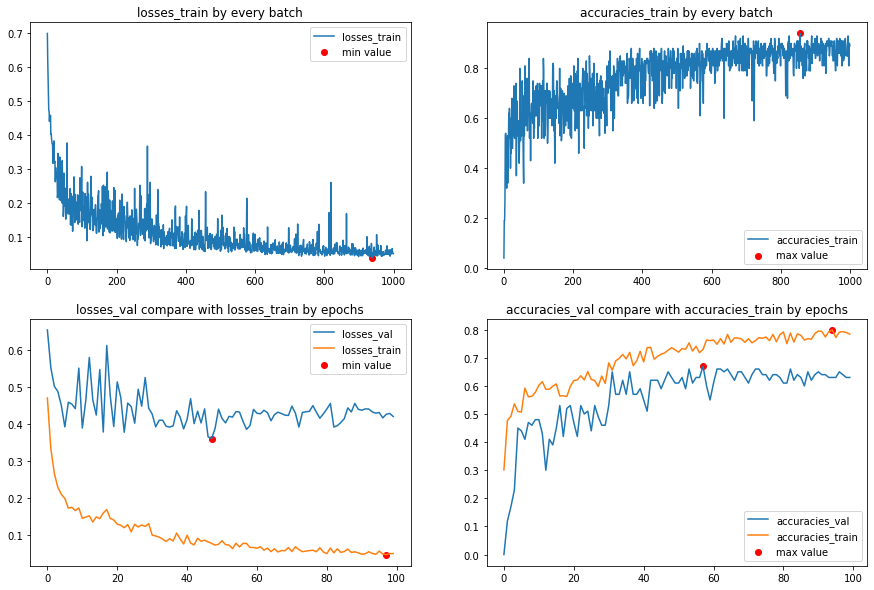

In [ ]:
values = [losses_train, accuracies_train, losses_val, accuracies_val]
avg_loss, avg_acc = avg_func(losses_train, accuracies_train)
visual(values, avg_loss, avg_acc)

А вот с этим графиком лоссов совсем проблемы. Разъехался очень сильно, получается, сеть переобучилась. Ну ничего, бывает, в следующий раз обучится нормально, верю.

In [ ]:
unet31 = score_model(unet_model_dice, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
unet_model_dice.load_state_dict(torch.load(folder_to_save))

<All keys matched successfully>

In [ ]:
unet32 = score_model(unet_model_dice, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
uaccs = {'bce':[unet11, unet12], 'dice':[unet31, unet32], 'focal':[unet21, unet22]}
udf = pd.DataFrame(data=uaccs, index=['last condition', 'best condition'])
udf

,bce,dice,focal
last condition,0.726,0.756,0.758
best condition,0.716,0.746,0.750


И вот, смотрим итоговое сравнение всех скоров...

In [ ]:
index = ['last condition', 'best condition']
merged = df.merge(udf, how='outer', left_index=True, right_index=True, suffixes=['_segnet', '_unet'])
merged

,bce_segnet,dice_segnet,focal_segnet,bce_unet,dice_unet,focal_unet
last condition,0.718,0.734,0.734,0.726,0.756,0.758
best condition,0.726,0.734,0.734,0.716,0.746,0.750


На мое удивление Unet с DiceLoss показал скор выше, чем у Unet BCELoss, но, впрочем, у меня была довольно субъективная оценка качества моделей. Числа сделали это лучше меня.

#Итак, отчет

Что было сделано? 
  В этом блокноте написаны две нейросетки, у которых одна общая цель: сегментировать дефекты кожи на картинках (родинки и меланомы). Я считаю, что получилось довольно неплохо и в целом все варианты нейросетей имеют довольно неплохой процент точности (порядка 73%) Последние две модели выделяется среди остальных своими более высокими точностями (~76%). Конечно, это далеко не идеал, но в датасете были и такие изображения, на которых я сам не смог найти границы поражений... Поэтому прощаю такие оплошности своей сеточке :)

Какие результаты ожидалось получить?
  В пределе хотелось бы очень точно по границам сегментировать изображения. Я не знал насколько это может быть возможно перед написанием сетки. И, честно говоря, я думал что такой простой сетки не будет достаточно для такой казалось бы сложной задачи. 

Какие результаты были достигнуты?
  Результаты по правде говоря меня очень порадовали. Да, мои сетки не точно сегментируют некоторые изображения я порой вообще делают очень странные ошибки. Но мы всегда замечаем только плохое и не видим хорошего, а ведь в некоторых случаях я прямо удивлялся как так точно они могли распознавать границы поражений. Порой у меня получались совсем красивые результаты (порядка 85%), а порой совсем не очень (порядка 60-65%). Результаты, конечно, зависили от рандома, поэтому я зафиксировал случайное зерно для всех рандом функций, чтобы вы смогли в будущем перезапустить этот код и убедиться, что он работает. Для каждой из 6 вариантов сеток я сделал графики лосс функций для трейна и для валидации, а также графики метрик на трейне и на валидации. Результаты получились довольно необычные. После каждого графика я оставлял небольшое описание что на нем происходит, чтобы было банально удобнее читать. Вообще советую все таки прочитать код программы целиком, чтобы избежать каких-то непониманий.

Давайте пройдемся по результатам каждой модели и сравним их:

1) SegNet, BCELoss ---- **score 0.718**. Самый низкий score среди всех моделей. Переобучения у этой модели не было. Что касается визуальной сегментации, я считаю, получилось довольно неплохо, по крайней мере на той небольшой выборке.

2) SegNet, DiceLoss ---- **score 0.734**. Тоже небольшой score, относительно остальных. Есть небольшой разрыв на графике лосса между тестовой и валидационной выборками, что свидетельствует о (возможно) небольшом переобучении сети. Я пытался с этим бороться, но то score получался меньше, то график лосса начал скакать как бешеный. Визуально эта модель сегментировала хуже, чем первая, но стоит учитывать, что это только небольшая часть выборки. Вероятно, на остальной части модель показала себя лучше. Интересно, что на валидационной выборке график метрики выше трейновой.

3) SegNet, FocalLoss ---- **score 0.734**. Хороший скор, относительно всех моделей, хотя и не самый высокий. На графике также присутствует гэп между лоссами валидационной и трейновой выборках. Визуальная сегментация этой сети мне не очень понравилась, тк одну картинку она совсем неправильно определила.

4) Unet, BCELoss ---- **score 0.726**. Плохой скор. Учитывая, что самая первая модель имела тоже плохой скор, скорее всего проблема в недостаточно хорошо подобранной лосс функции. Что касается визуальной сегментации, по моему мнению, у этой сети самый хороший результат. Все картинки были очень хорошо сегментированы прямо до мелочей.

5) Unet, DiceLoss ---- **score 0.756**. (Если что, график этой модели не предпоследний, а последний). Очень хороший скор. Визуальная сегментация также получилась очень хорошей, зато на график лосса невозможно смотреть без боли. Большой разрыв -> сеть переобучилась под тестовую выборку. Такая модель, хотя и имеет очень большую точность, не может называться самой хорошей.

6) Unet, FocalLoss ---- **score 0.758**. (А эта модель обучалась у меня пятой по счету, а не шестой, как в этом списке). Самый высокий скор вреди всех моделей. Визуальная сегментация получилась тоже почти идеальной, даже не смотря на то, что экземпляры попались не самые простые. Есть гэп на графике лоссов, но он не такой критичный, как в случае DiceLoss. Поэтому, я считаю, что именно эта модель лучше всего подходит для решения этой задачи сегментации.

Вообще, визуальная сегментация у SegNet выглядит так, как будто она замылена чем-то, сглажена. У Unet этой проблемы нет и четко виден каждый пиксель к какому он классу принадлежит. Я считаю, это большой плюс, т.к. даже внутри самой области поражения есть участки, которые (по крайней мере так кажется мне, я не разбираюсь в этом) не поражены и являются простой кожей.

***ИТОГ:*** Лучшая сеть - Unet, лучшая loss функция для нее - FocalLoss.